In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
from fastai.basics import *
import json
from tqdm import tqdm

import jkbc.model as m
import jkbc.utils.constants as constants
import jkbc.utils.torch_files as f
import jkbc.utils.general as g
import jkbc.utils.metrics as metric
import jkbc.utils.preprocessing as prep

In [3]:
# Initialise random libs and setup cudnn
random_seed = 25 # MAGIC!!
random.seed(random_seed)
np.random.seed(random_seed)
torch.manual_seed(random_seed)
torch.backends.cudnn.enabled = True
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

## Constants

### Data

In [4]:
BASE_DIR = Path("../../..")
PATH_DATA = 'data/feather-files'
DATA_SET = 'Range0-10000-FixLabelLen400-winsize4096'
FEATHER_FOLDER = BASE_DIR/PATH_DATA/DATA_SET

with open(FEATHER_FOLDER/'config.json', 'r') as fp:
    config = json.load(fp)

ALPHABET       = constants.ALPHABET
ALPHABET_SIZE  = len(ALPHABET.keys())
WINDOW_SIZE    = int(config['maxw']) #maxw = max windowsize
DIMENSIONS_OUT = int(config['maxl']) # maxl = max label length
STRIDE         = WINDOW_SIZE

KNOWLEGDE_DISTILLATION = False
TEACHER_OUTPUT = 'bonito-pretrained-Valid[3.625368118286133]-CTC[90.3227304562121]' # Set to name of y_teacher output
if KNOWLEGDE_DISTILLATION and not TEACHER_OUTPUT:
    print('WARNING! Must provide name of teacher output when doing knowledge distillation')

### Train/Predict

In [5]:
LR = 1e-3  # default learning rate
BS = 2**6  # batch size
EPOCHS = 400
DEVICE = torch.device("cuda:0") #torch.device("cpu")

### Model

In [6]:
import bonito_basic as model_file
DIMENSIONS_PREDICTION_OUT = WINDOW_SIZE//3+1
DROP_LAST = False # SET TO TRUE IF IT FAILS ON LAST BATCH
model, MODEL_NAME = model_file.model(DEVICE, WINDOW_SIZE, DIMENSIONS_PREDICTION_OUT)
MODEL_NAME = f'{MODEL_NAME}-windowsize={WINDOW_SIZE}'
MODEL_DIR = f'weights/{MODEL_NAME}'
SPECIFIC_MODEL_WEIGHTS = None #'bonito-pretrained-Valid[1.545677900314331]-CTC[91.66666666666667]' #Set to specific name of model ('None' uses the newest)

### Loss, metrics and callback

In [7]:
_ctc_loss = metric.CtcLoss(WINDOW_SIZE, DIMENSIONS_PREDICTION_OUT, BS, ALPHABET_SIZE)
_kd_loss = metric.KdLoss(alpha=.3, temperature=5, label_loss=_ctc_loss)
LOSS_FUNC = _kd_loss.loss() if KNOWLEGDE_DISTILLATION else _ctc_loss.loss()
#LOSS_FUNC = nn.CTCLoss()
METRICS = []#[metric.ctc_accuracy(ALPHABET, 5)]
SAVE_CALLBACK = partial(metric.SaveModelCallback, every='epoch', monitor='valid_loss')

## Load data

In [8]:
# Read data from feather
data = f.load_training_data(FEATHER_FOLDER) 

# Convert to databunch
train_dl, valid_dl = prep.convert_to_dataloaders(data, split=.8, batch_size=BS, drop_last=DROP_LAST)
databunch = DataBunch(train_dl, valid_dl, device=DEVICE)

## Model

In [9]:
optimizer = partial(torch.optim.AdamW, amsgrad=True, lr=LR)

In [10]:
learner = Learner(databunch, model, loss_func=LOSS_FUNC, model_dir=MODEL_DIR, metrics=METRICS, opt_func=optimizer)

In [ ]:
#m.load_model_weights(learner, SPECIFIC_MODEL_WEIGHTS)

## Train

In [ ]:
#learner.lr_find()
#learner.recorder.plot(suggestion=True)

In [11]:
# Default to LR if lr_find() has not been run
try: lr = learner.recorder.min_grad_lr
except: lr = LR
lr = LR

In [12]:
learner.fit(EPOCHS, lr=lr, callbacks=[SAVE_CALLBACK(learner)])

epoch,train_loss,valid_loss,time
0,0.158281,0.150863,1:42:38
1,0.099687,0.103246,1:42:35
2,0.075319,0.082522,1:42:33
3,0.060427,0.070214,1:42:32
4,0.051279,0.060069,1:42:30
5,0.046517,0.059549,1:42:29
6,0.045783,0.058853,1:42:29


KeyboardInterrupt: 

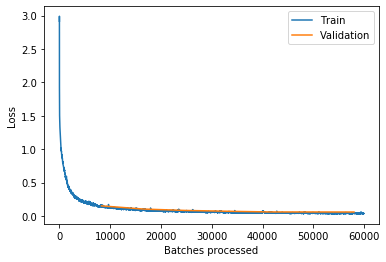

In [13]:
learner.recorder.plot_losses()

## Predict

In [14]:
sc = prep.SignalCollection(BASE_DIR/constants.MAPPED_READS, training_data=False, stride=1, window_size=(WINDOW_SIZE-1, WINDOW_SIZE), blank_id=constants.BLANK_ID)
validate_signal_count = 1

In [20]:
#for index in range(validate_signal_count): 
# Get read object (signal and reference)
read_object = sc[5]
# Predict signals
x = read_object.x
x_size= len(x)
outputs = []
x = torch.tensor(read_object.x, dtype=torch.float32)
for from_ in tqdm(range(0, x_size, 100)):
    to = min(x_size-1, from_+100)
    x_ = m.signal_to_input_tensor(x[from_:to], DEVICE)
    outputs += learner.model(x_).detach().cpu()

100%|██████████| 552/552 [02:19<00:00,  3.97it/s]


In [21]:
assembled, (accuracy, alignment) = m.predict(learner, outputs, ALPHABET, WINDOW_SIZE, 1, read_object.reference, beam_size=500, beam_threshold=0.1)

In [23]:
accuracy, alignment

(0.29857369255150557,
 'CCGGGCGAAGCCAGACCGCACAGCCACCACGCAAGGAGCACGACCACACCACCCAGGCAGGAGAGCGCGGCACCACCACCCGCCGAACGCCGAAGAAGGCAGCCCGAGGACCCAACCCAGGAACCGGGGGGCAACAGCCGGACGCCACCGAGGCAGCGAAGGGCGCCGAACACAGCAGGCAGCGGCCGCCGACCAGGAACCAACGCAGCAACAAGCCCCCGCGACCAAAAGCCAGCCAACCGAACAGAAGACCCCCACACGCCCGAGGAACAGCCCACCAAGCACCCAACAACACGCCGCGCCCGA-GGACCGACGAGAGCGGGGCCCCAGGCGCGCGAGCGCAAGAGGCACCGAAGGACCAAACCAGAGACGCAACACAACACCGGACGCCGCCACACGGGAACCGGGGCCCACGCACACACGCCACCGGGGGGCGAGCGCGCCAAAACCAGAAACGCCCCCGAGGCCAGCCAGGCCGCACCCCCGCCGGAAGCGCGCACCGCGCACACCGGCCCCAAACGCCACCCACAGGGAGCCGAGCGAGCACAGCGCGCACCACGCCCCGAACCGGCGAAAGCCGCGAAACAACGACGCCGCAGCGCGGCCCCCGGGAACAAAAGGCGCAGCACAGACAGGCAAGAACAAGCCCCCGACAACACCGGCAGACCGGCACCCCAAACAACACCGCCCAGCGCCGGGGGAC-CAACACCAAGGAAGAGGCAGAAGGGCAAGAGCCGCCAGGGAAAAGGACCCCCACGCACCGCCGCAGCCGGCGACGACAGACGCGACGCCGCGGCCCGGCGAAACAACCACAAAAGGCAGGCGGCAAGAGGCGGCCCAAGAGCGGCAGCAACCGCAAACCCCCCGCCCCGCACGAGAGAGCAAAAGGGCGGGCCCAGAAACGCAGAGCCAGACCCACACAACACCCGACAGAAAGCGGCGGAGACGGACCGGCGCGAGCAAGACAGAGCCAG